# Удержание клиентов фитнес-центра

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов — отток клиентов.

**Цель исследования**

Провести анализ и подготовить план действий по удержанию клиентов.

1. Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

**Описание данных**

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. 

Путь к файлу: `/datasets/gym_churn.csv`

Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:

* gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* Churn — факт оттока в текущем месяце.


**Ход исследования:**

1. Обзор и подготовка данных.
2. Исследовательский анализ данных.
3. Построение модели прогнозирования оттока клиентов.
4. Кластеризация клиентов.
5. Общий вывод и рекомендации.

## Обзор и подготовка данных

### Импорт библиотек

В первую очередь импортируем необходимые для исследования библиотеки.

In [1]:
import numpy as np # импорт библиотеки numpy
import pandas as pd # импорт библиотеки pandas
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

### Изучение данных из файла

Сохраним данные о клиентах переменную, приведем названия столбцов к нижнему регистру и выведем таблицу на экран для ознакомления.

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv') # сохранение таблицы в переменную
df.columns = df.columns.str.lower() # приведение названий столбцов к нижнему регистру
df.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Проверим датасет на наличие пропусков и соответствие типам данных.

In [3]:
df.info() # обзор сведений о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков нет, а данные в ячейках соответствуют типам данных в столбцах. Мы не будем проверять датасет на наличие дубликатов, так как нет столбца с уникальным значением. На этом этап подготовки данных завершен и можно переходить к исследованию.

## Исследовательский анализ данных

На этом этапе проведем исследовательский анализ признаков.

### Обзор признаков

Посмотрим на средние значения и стандартные отклонения.

In [4]:
df.describe() # обзор значений в столбцах

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Средние и стандартные отклонения количественных и категориальных переменных выглядят корректно, выбросов нет. 

Cформируем "портрет типичного клиента":

Клиент мужчина или женщина (в равных пропорциях) в среднем около 30 лет, который живет или работает недалеко от фитнес центра, возможно сотрудник компании-партнера клуба (вероятность 50%) и возможно воспользовался акцией "Приведи друга" (вероятность 30%). Клиент оставил номер телефона и скорее всего приобрел абонемент на пол года, который закончится в среднем через 4 месяца. Клиент начал ходить в фитнес-центр в среднем 4 месяца назад, посещает его 2 раза в неделю и потратил в среднем 150$ на другие услуги фитнес-центра.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (0 - остался, 1 - ушел).

In [5]:
df.groupby('churn').mean() # средние значения с группировкой по факту оттока

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Значения средних в некоторых столбцах сильно отличается для тех, кто ушел и тех, кто остался. Предварительно поделим признаки на количественные и категориальные для дальнейшего анализа.

In [6]:
qua_col = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', # количественные столбцы
             'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
cat_col = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'] # категориальные столбцы

### Графики

Построим столбчатые диаграммы и посмотрим распределения количественных признаков для тех, кто ушёл и тех, кто остался.

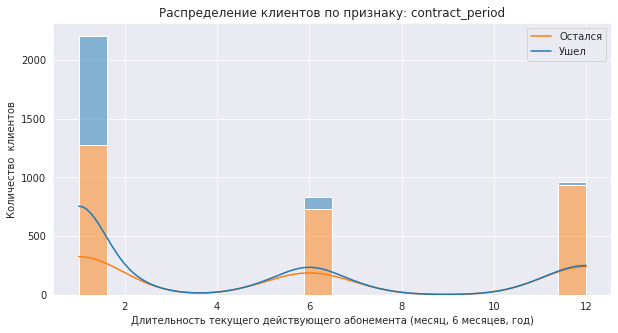

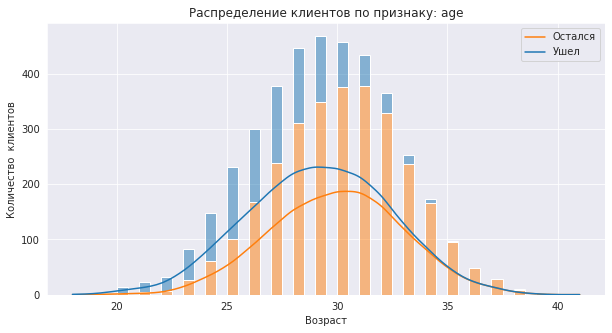

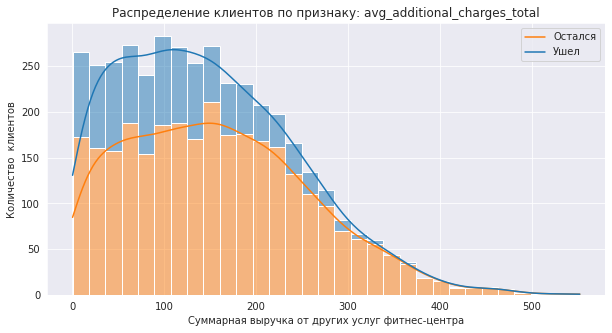

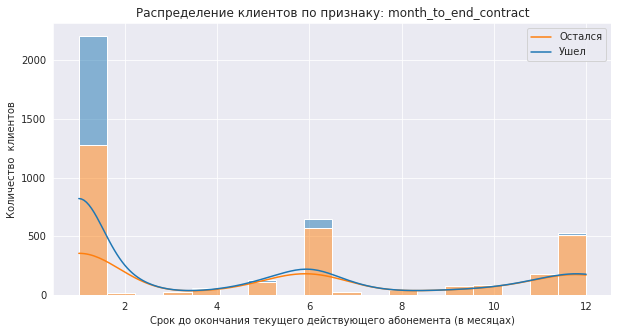

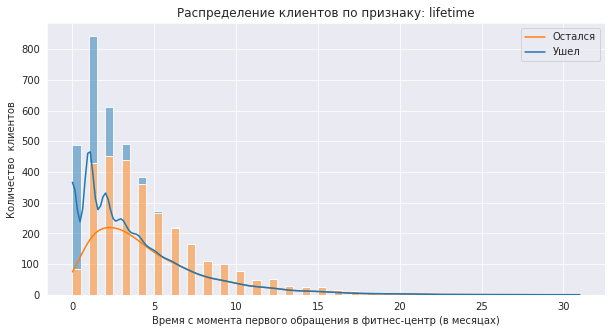

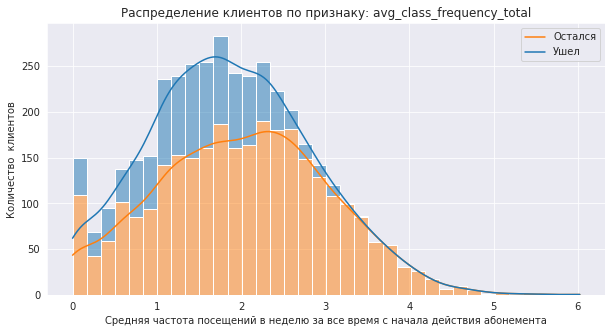

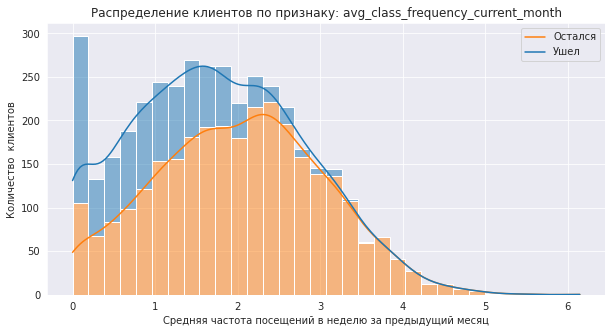

In [8]:
qua_labels = ['Длительность текущего действующего абонемента (месяц, 6 месяцев, год)',  # список названий столбцов для графиков
              'Возраст',
              'Cуммарная выручка от других услуг фитнес-центра',
              'Cрок до окончания текущего действующего абонемента (в месяцах)',
              'Время с момента первого обращения в фитнес-центр (в месяцах)',
              'Средняя частота посещений в неделю за все время с начала действия абонемента',
              'Средняя частота посещений в неделю за предыдущий месяц'
         ]

for col, label in zip(qua_col, qua_labels): # цикл для построения графиков
    plt.figure(figsize=(10, 5))
    hue_order = [1, 0]
    sns.histplot(data=df, x=col, hue='churn', kde=True, hue_order = hue_order, multiple='stack')
    plt.legend(['Остался', 'Ушел'])
    plt.title('Распределение клиентов по признаку: ' + col)
    plt.xlabel(label)
    plt.ylabel('Количество  клиентов')
    plt.show()
    print()

По графикам распределения количественных переменных можно сделать следующие наблюдения:

* У большинства клиентов, которые попали в отток, был приобретен короткий абоненмент на месяц
* Есть небольшое смещение возраста в меньшую сторону для тех, кто попал в отток.
* Cуммарная выручка от других услуг фитнес-центра ниже у клиентов из оттока.
* У большинства клиентов из оттока заканчивался срок действующего абонемента.
* Большинство клиентов из оттока начали ходить в зал не более 4 месяцев назад.
* Большинство клиентов из оттока ходили в зал от 1 до 3 раз в неделю за весь период действия абонемента, в том числе и в предыдущий месяц.

Построим столбчатые диаграммы распределения категориальных признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

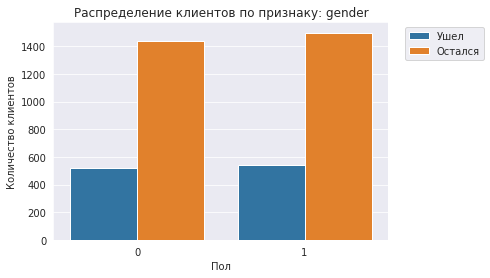

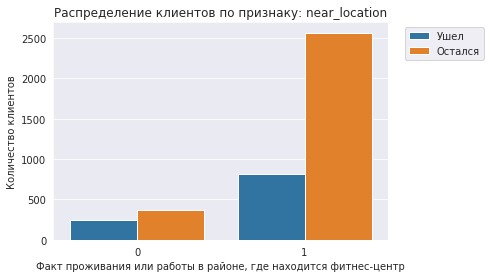

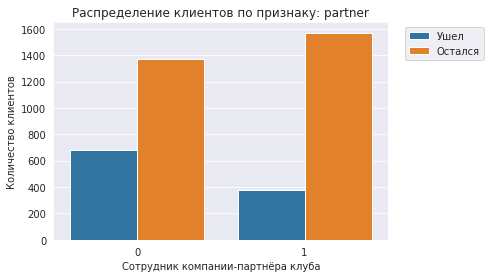

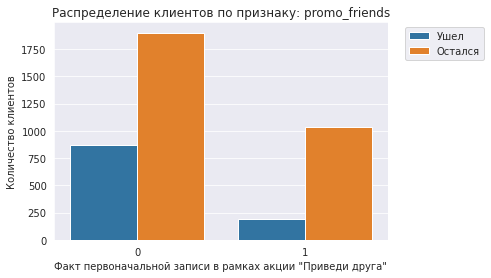

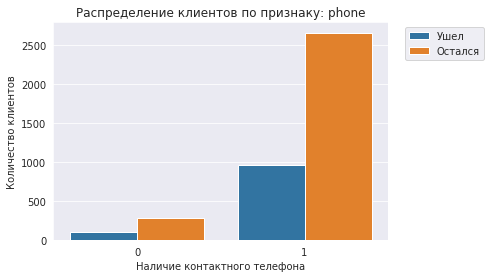

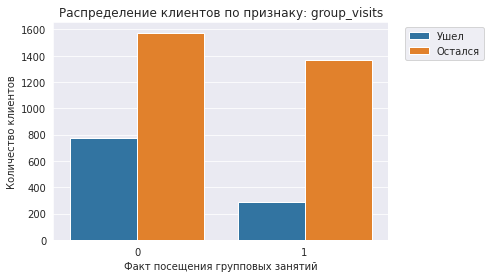

In [8]:
cat_labels = ['Пол',
              'Факт проживания или работы в районе, где находится фитнес-центр',
              'Сотрудник компании-партнёра клуба',
              'Факт первоначальной записи в рамках акции "Приведи друга"',
              'Наличие контактного телефона',
              'Факт посещения групповых занятий'
         ]

for col, label in zip(cat_col, cat_labels):
    hue_order = [1, 0]
    sns.countplot(data=df, x=col, hue='churn', hue_order = hue_order)
    plt.title('Распределение клиентов по признаку: ' + col)
    plt.xlabel(label)
    plt.ylabel('Количество клиентов')
    plt.legend(['Ушел', 'Остался'], bbox_to_anchor=(1.3, 1))
    plt.show()
    print()

По графикам распределения категориальных переменных можно сделать следующие наблюдения:

* Примерно одинаковое соотношение клиентов разных полов из оттока и тех, кто остался;
* Большинство клиентов, которые живут или работают недалеко от фитнес-центра, не попали в отток;
* В отток попало больше клиентов-сотрудников компании-партнёра клуба;
* В отток попало больше клиентов, не участвовавших в акции Приведи друга;
* В отток попало больше клиентов, у которых указан номер телефона;
* В отток попало больше клиентов, которые не посещали групповые занятия.

Построим матрицу корреляций и ее тепловую карту.

In [9]:
matrix = round(df.corr(), 2) # матрица корреляции

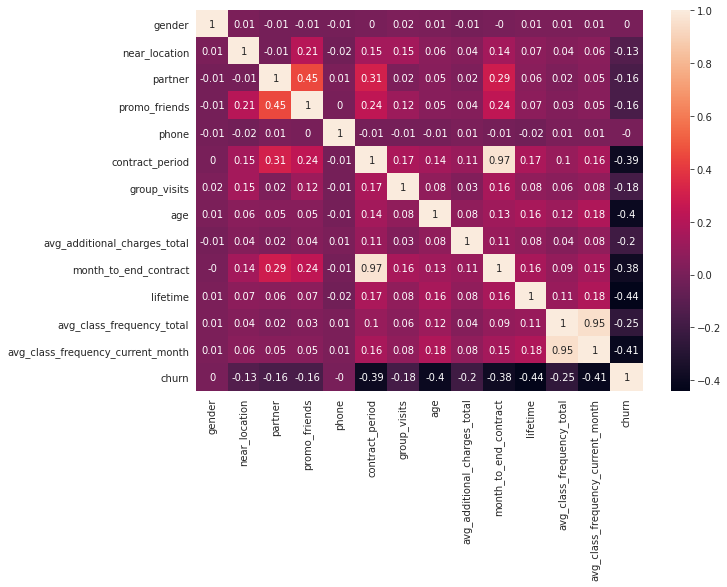

In [10]:
plt.figure(figsize=(10, 7)) # тепловая карта
sns.heatmap(matrix, annot=True)
plt.show()

Из графика можно сделать следующие наблюдения:

* Длительность текущего действующего абонемента сильно коррелирует со сроком до его окончания;
* Средняя частота посещений в неделю за все время с начала действия абонемента сильно коррелирует со средней частотой посещений в неделю за предыдущий месяц;
* Наблюдается средняя по силе корреляция между признаками "Сотрудник компании-партнёра клуба" и участии в программе "Приведи друга".

Для того, чтобы избавиться от мультиколлинеарности, удалим из этих пар по одному столбцу.

In [11]:
df = df.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month']) # убираем один из пары коррелирующих признаков

### Вывод

Мы провели исследовательский анализ данных. Рассомтрели средние и стандартные отклонения количественных и категориальных переменных. Мы построили графики распределения признаков и сделали промежуточные выводы на основе наблюдений, а также построили матрицу корреляций.

## Построение модели прогнозирования оттока клиентов

На этом этапе построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Выборки

Разделим данные на обучающую и валидационную выборки.

In [12]:
X = df.drop('churn', axis = 1) # признаки
y = df['churn'] # целевая переменная
X_train, X_test, y_train, y_test = train_test_split( # разделение на тестовую и валидационную выборки
    X, y, test_size=0.2, random_state=0)

### Обучение моделей

Обучим модель на train-выборке двумя способами:
1. Логистической регрессией.
2. Случайным лесом.

In [13]:
lr_model = LogisticRegression(solver='liblinear', random_state = 0) # модель логистической регрессии
lr_model.fit(X_train, y_train) # обучение модели
lr_predictions = lr_model.predict(X_test) # прогноз
lr_probabilities = lr_model.predict_proba(X_test)[:,1] # вероятность принадлежности

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

### Метрики

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [14]:
def print_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
print_metrics(
    y_test, lr_predictions, lr_probabilities,
    title='Метрики для модели логистической регрессии:')

print()
print_metrics(
    y_test, rf_predictions, rf_probabilities,
    title='Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.88
	Precision: 0.76
	Recall: 0.77

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.78
	Recall: 0.77


Модель случайного леса показала лучшие значения доли правильных ответов, точности и полноты.

### Вывод

Мы разделили данные на обучающую и валидационную выборки. Далее мы обучили модель на train-выборке методами логистической регрессии и случайного. Мы оценили метрики accuracy, precision и recall и на их основании модель случайного леса показала себя лучше.

## Кластеризация клиентов

На этом этапе проведем кластеризацию объектов. В первую очередь стандартизируем данные.

In [15]:
sc = StandardScaler()
x_sc = sc.fit_transform(X) # стандартизируйте обучающую выборку методом transform scaler

### Агломеративная иерархическая кластеризация

Построим матрицу расстояний функцией на стандартизованной матрице признаков и нарисуем дендрограмму.

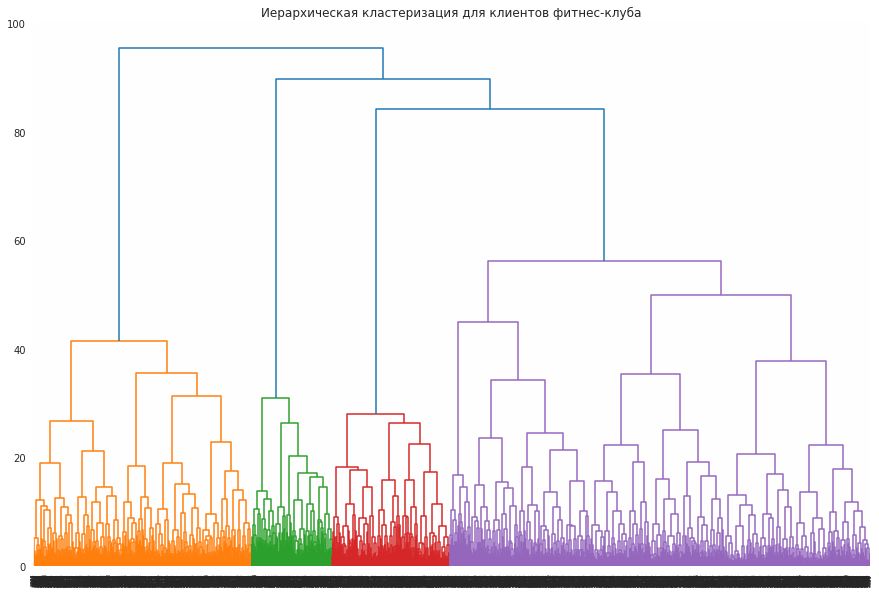

In [16]:
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для клиентов фитнес-клуба')
plt.show()

Договоримся за число кластеров принять n=5.

### Алгоритм K-Means

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Укажем число кластеров 5.

In [17]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 4, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) # прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
df['cluster'] = labels # сохраняем метки кластера в поле датасета

### Кластеры

Посмотрим на средние значения признаков для кластеров.

In [18]:
df.groupby('cluster').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Сразу можно выделить следующие наблюдения.

В кластерах 1 и 4 высокие средние значения:

* сотрудник компании-партнёра клуба
* участие в акции "Приведи друга"
* длительность текущего действующего абонемента
* суммарная выручка от других услуг фитнес-центра
* время с момента первого обращения в фитнес-центр

Кластер 3 выделяется высокими средними значеними:

* факт посещения групповых занятий
* суммарная выручка от других услуг фитнес-центра
* длительность текущего действующего абонемента

В кластере 0 нет клиентов, которые проживают или работают в районе, где находится фитнес-центр. У кластера 2 самая низкая средняя длительность текущего действующего абонемента.


Построим распределения признаков для кластеров. Снова выделим категориальные и количественные признаки, начнем с количественных.

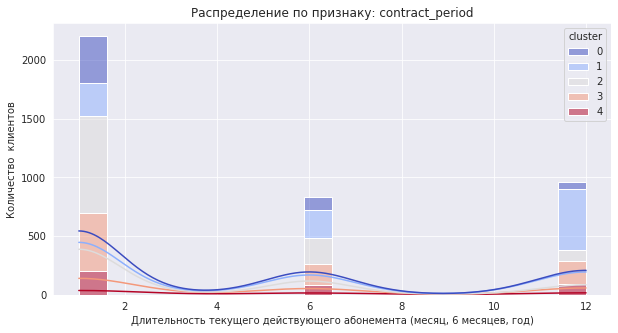

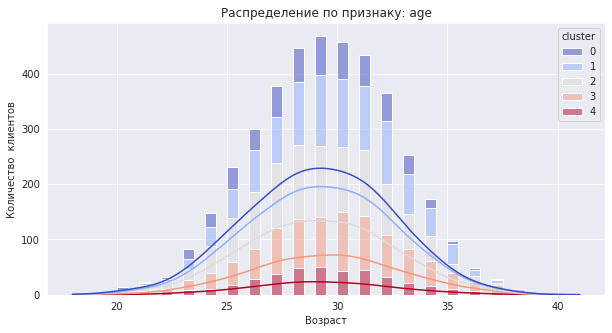

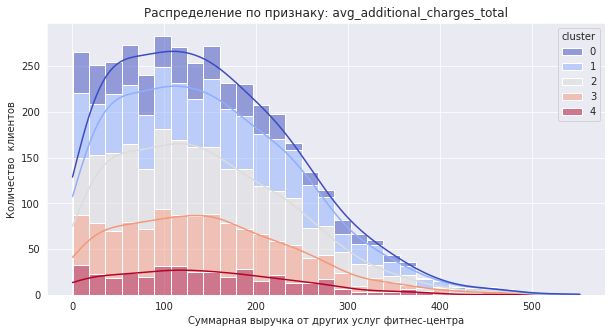

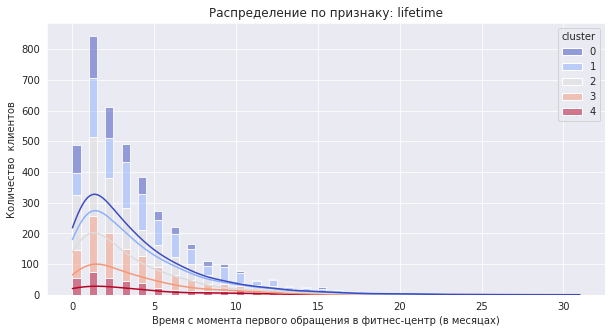

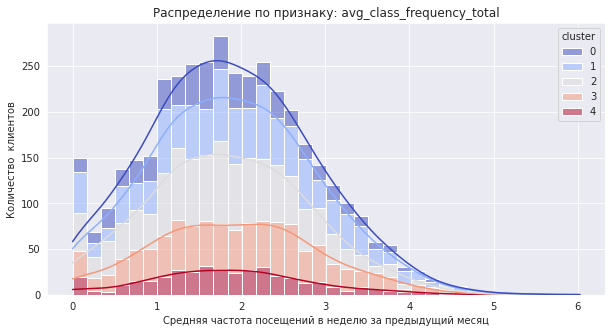

In [19]:
qua_col_cl = ['contract_period', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']

qua_labels_cl = ['Длительность текущего действующего абонемента (месяц, 6 месяцев, год)',
                 'Возраст',
                 'Cуммарная выручка от других услуг фитнес-центра',
                 'Время с момента первого обращения в фитнес-центр (в месяцах)',
                 'Средняя частота посещений в неделю за предыдущий месяц']

for col, label in zip(qua_col_cl, qua_labels_cl):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=col, hue='cluster', kde=True, multiple='stack', palette='coolwarm')
    plt.title('Распределение по признаку: ' + col)
    plt.xlabel(label)
    plt.ylabel('Количество  клиентов')
    plt.show()
    print()

Все количественные признаки распределены практически равномерно. Посмотрим на распределение категориальных признаков.

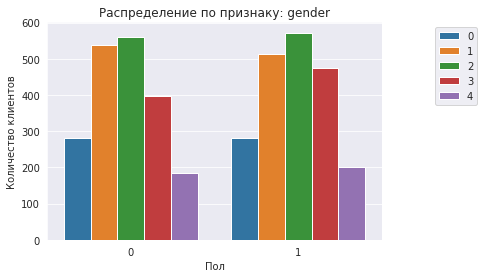

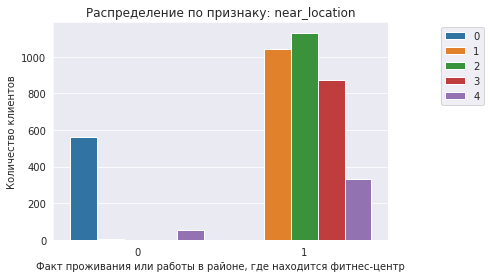

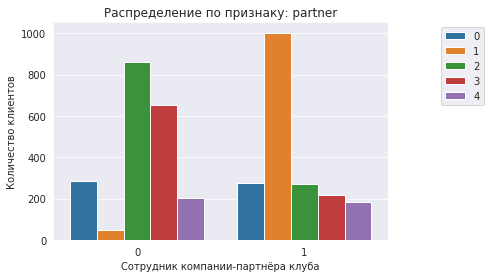

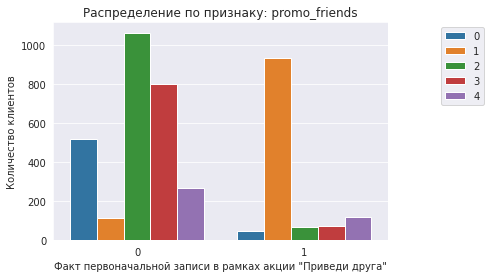

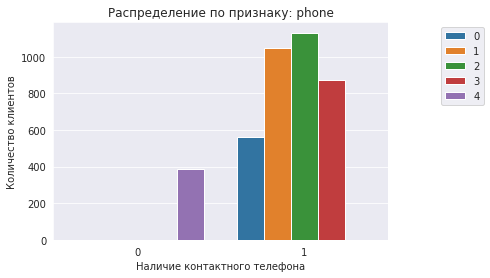

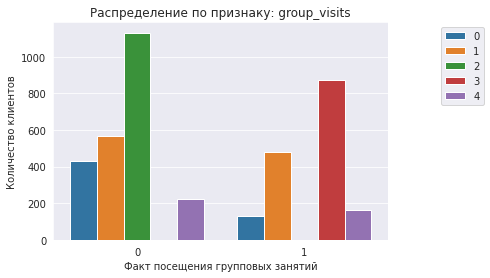

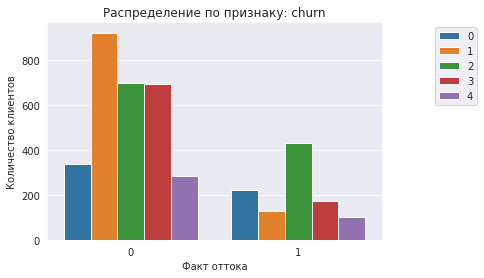

In [20]:
cat_col_cl = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

cat_labels_cl = ['Пол',
                 'Факт проживания или работы в районе, где находится фитнес-центр',
                 'Сотрудник компании-партнёра клуба',
                 'Факт первоначальной записи в рамках акции "Приведи друга"',
                 'Наличие контактного телефона',
                 'Факт посещения групповых занятий',
                 'Факт оттока']

for col, label in zip(cat_col_cl, cat_labels_cl):
    sns.countplot(data=df, x=col, hue='cluster')
    plt.title('Распределение по признаку: ' + col)
    plt.xlabel(label)
    plt.ylabel('Количество клиентов')
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()
    print()

По графикам можно сделать следующие наблюдения:

* В кластере 0 самая низкая близость фитнес-центра от района проживания или работы
* Больше всего сотрудников компании-партнёра клуба в кластере 1
* Больше всего участников акции "Приведи друга" в кластере 1, меньше всего - в кластере 2
* Клиенты из кластера 2 реже остальных ходят на групповые занятия, в отличие от клиентов из кластера 3 - самый высокий показатель посещения.
* Самый большой отток клиентов из кластера 2

Посчитаем долю оттока для каждого кластера и отсортируем их.

In [21]:
df_churn = df.query('churn == 1')

churn_cl = df_churn.groupby('cluster')['churn'].count().to_frame()
churn_cl.columns = ['churn_clients']
churn_cl['churn_rate'] = round(churn_cl['churn_clients'] / len(df_churn), 2)
churn_cl.sort_values(by='churn_rate')

,churn_clients,churn_rate
cluster,,
4,103,0.10
1,127,0.12
3,175,0.16
0,224,0.21
2,432,0.41


Кластеры отличаются по доле оттока:

* кластер 2 склоннен к оттоку
* кластеры 4 и 1 надежны

Кластеры 3 и 0 не так склонны к оттоку как кластер 2, но показатели оттока у них выше, чем у кластеров 4 и 1.

### Вывод

Мы провели кластеризацию объектов, построили дендрограмму и спрогнозировали 5 кластеров на основании алгоритма K-Means. Мы сделали наблюдения на средних значениях признаков на основании кластеризации, а также построили графики распределения признаков для кластеров. Мы посчитали долю оттока для каждого кластера: кластер 2 склоннен к оттоку, 4 и 1 - надежны, 3 и 0 занимают промежуточное положение.

## Общий вывод и рекомендации

Целью исследования было Провести анализ и подготовить план действий по удержанию клиентов.

Мы подготовили данные и провели исследовательский анализ, построили модель прогнозирования оттока и выполнили кластеризацию клиентов.

Модель случайного леса показала лучшие значения доли правильных ответов, точности и полноты. Метрики для модели случайного леса:
* Доля правильных ответов: 0.89
* Точность: 0.78
* Полнота: 0.77

Мы спрогнозировали 5 кластеров клиентов и посчитали долю оттока для каждого кластера.
    
    
По итогам исследования можно сформулировать свойства клиентов, которые попадют в отток:

* короткий срок абонемента или его срок заканчивается
* начали ходить в фитнес-центр недавно (3-4 месяца)
* живут или работают далеко от фитнес-центра
* не учавствовали в акции "Приведи друга"
* редко посещают групповые занятия


Свойства клиентов, которые не попадют в отток:

* сотрудник компании-партнёра клуба
* участие в акции "Приведи друга"
* абонемент длительного срока действия
* высокая суммарная выручка от других услуг фитнес-центра
* ходят в фитнес-центр длительное время
* часто посещают групповые занятия

Можно также выделить целевые группы клиентов для удержания.

1. Клиенты, которые вероятно ходят в зал одиночку. Они не участвовали в акции "Приведи друга", не являются сотрудниками компании-партнёра клуба и редко послещают групповые программы.
2. Клиенты, которые живут и работают далеко от фитнес-центра.
3. Клиенты, у которых короткий абонемент или он заканчивается.


На основе представленных портретов клиентов, можно предложить следующие рекомендации для взаимодействия с ними.

* Группа 1

Увеличить взаимодействие с клиентами среди персонала фитнес-цетра, а также между клиентами. Выделить тренеров, которые будут находиться в зале для бесплатных консультаций. Добавить в групповые программы командные виды спорта. Увеличить активность ведения соцсетей. 

* Группа 2

Рассмотреть возмоность расширения финтнес-центра в других перспективных районах. Проводить выездные групповые программы на общественных спортплощадках в других районах.

* Группа 3

Предложить скидку на продление абонемента.